In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

In [2]:
np.set_printoptions(threshold=100000, precision=4, linewidth=10000)
ps_conf = ps.SparkConf().set("spark.logConf", "false")\
            .set("spark.executor.memory", "12g")\
            .set("spark.driver.memory", "4g")\
            .set("spark.executor.cores", "7")\
            .set("spark.sql.shuffle.partitions", "500")\
            .set("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:+UseStringDeduplication")\
            .set("spark.eventLog.gcMetrics.youngGenerationGarbageCollectors", "G1 Young Generation")\
            .set("spark.eventLog.gcMetrics.oldGenerationGarbageCollectors", "G1 Old Generation")\
			.set("spark.logConf", "false")
spark = SparkSession.builder.config(conf=ps_conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 14:59:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20241120"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [4]:
input_path  = SPECIFIED_CSV + "_raw_data_sumida_bunka.csv"
df_raw_data = spark.read.option("inferSchema", "True").option("header", "True").csv(input_path)
df_raw_data.persist(StorageLevel.MEMORY_AND_DISK_DESER)

utid_list = sorted(df_raw_data.select("unit_id").drop_duplicates().rdd.flatMap(lambda x: x).collect())

25/01/27 15:00:15 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
df_raw_data\
		.filter(col("unit_id").isin(utid_list))\
		.filter(col("randomized") == 1)\
		.select(['date', 'datetime', 'unit_id', 'aibeaconid'])\
        .withColumn('minute', F.date_trunc('minute', 'datetime'))\
        .withColumn('minute', F.unix_timestamp('minute'))\
        .withColumn('minute', col('minute') - (col('minute') % 60))\
        .withColumn('minute', F.from_unixtime('minute'))\
        .select(['date', 'minute', 'unit_id', 'aibeaconid'])\
        .drop_duplicates()\
        .groupBy(['date', 'minute', 'unit_id'])\
        .agg(F.count('*').alias('1min_count'))\
        .orderBy(['date', 'minute', 'unit_id'])\
        .toPandas()\
        .to_csv(SPECIFIED_CSV + "_1min_data_sumida_bunka.csv", header=True, index=False)

25/01/27 15:00:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/27 15:00:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/27 15:00:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/27 15:00:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/27 15:00:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/27 15:00:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/27 15:00:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/27 15:00:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/01/27 15:00:33 WARN RowBasedKeyValueBatch: Calling spill() on

In [6]:
SPECIFIED_PAST = (datetime.datetime.strptime(SPECIFIED_DATE, '%Y%m%d') - relativedelta(days=1) + datetime.timedelta(hours=9)).strftime('%Y-%m-%d')

start_time = f'{SPECIFIED_PAST} 00:00:00'
end_time = f'{SPECIFIED_PAST} 23:59:00'
# 1分単位の時間列を作成
time_range = pd.date_range(start=start_time, end=end_time, freq='min')
# DataFrameに変換
df_time = pd.DataFrame(time_range, columns=['datetime'])
df_time = spark.createDataFrame(df_time)\
				.withColumn('hour', F.hour(col('datetime')))

df_by1min = spark.read\
				.option('header', True)\
				.option('inferSchema', True)\
           		.csv(SPECIFIED_CSV + "_1min_data_sumida_bunka.csv")

for unit_id in utid_list:
    df_tmp  = df_by1min\
        		.filter(col('unit_id') == unit_id)\
          		.select(['minute', '1min_count'])\
            	.withColumnRenamed('minute',     'datetime')\
                .withColumnRenamed('1min_count', unit_id)
    df_time = df_time.join(df_tmp, on='datetime', how='left')
df_time = df_time\
			.fillna(0)\
    		.orderBy('datetime')
df_time.persist(StorageLevel.MEMORY_AND_DISK_DESER)
df_time.show()

25/01/27 15:00:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------------------+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|           datetime|hour|1002A25B|1002A25C|1002A25D|1002A5BA|1002A5BB|1002A5BD|1002A5BE|1002A5BF|1002A5C1|1002A5C3|1002A5C4|1002A5C5|1002A5C6|1002A5C7|1002A5C9|1002A5CA|1002A5CB|1002A5CC|1002A5CE|1002A5CF|1002A5D0|1002A5D1|1002A6A5|1002A6A7|1002A6A8|1002A6AF|1002A6B0|1002A6B2|1002A6B3|1002A6B6|1002A6B9|1002A6BA|1002A6BC|1002A6BD|1002A6BE|10

In [7]:
SPECIFIED_HOUR = 14

pd_data = df_time.toPandas()
pd_data = pd_data[pd_data['hour'] == SPECIFIED_HOUR]
pd_data = pd_data[utid_list]
pd_data

,1002A25B,1002A25C,1002A25D,1002A5BA,1002A5BB,1002A5BD,1002A5BE,1002A5BF,1002A5C1,1002A5C3,...,1002ABE5,1002ABE8,1002ABF2,1002ABF3,1002ACA9,1002ACAA,1002ACB0,1002ACB2,1002ACB8,1002ACB9
840,27,29,41,31,30,36,1,18,24,0,...,41,49,5,42,57,21,67,2,11,8
841,19,18,53,25,23,36,3,18,24,3,...,45,52,5,32,49,17,64,6,20,2
842,10,14,52,18,15,13,1,14,12,0,...,56,67,14,48,65,10,71,8,15,12
843,7,23,72,27,13,20,3,15,8,0,...,52,43,3,45,56,18,66,0,21,0
844,6,24,65,27,15,27,2,11,10,0,...,61,72,5,51,80,14,81,3,28,1
845,5,16,57,22,15,22,2,14,5,0,...,48,59,5,43,68,10,73,2,13,2
846,9,20,42,20,16,21,2,14,16,0,...,67,91,7,68,97,14,84,7,15,5
847,11,18,41,24,19,19,5,14,18,0,...,71,105,6,71,101,17,87,7,13,5
848,5,17,64,23,11,19,3,7,10,0,...,73,84,6,64,85,13,89,5,16,3
849,11,24,48,30,13,21,4,13,10,2,...,79,65,5,61,75,8,96,5,18,2


In [8]:
test_data = pd_data.values.tolist()
test_data

[[27,
  29,
  41,
  31,
  30,
  36,
  1,
  18,
  24,
  0,
  37,
  59,
  10,
  12,
  21,
  4,
  59,
  55,
  31,
  52,
  50,
  30,
  51,
  16,
  4,
  44,
  12,
  39,
  51,
  46,
  10,
  3,
  37,
  3,
  33,
  26,
  40,
  47,
  0,
  34,
  42,
  40,
  56,
  38,
  18,
  16,
  49,
  66,
  76,
  24,
  5,
  46,
  0,
  41,
  7,
  55,
  76,
  33,
  22,
  40,
  41,
  49,
  5,
  42,
  57,
  21,
  67,
  2,
  11,
  8],
 [19,
  18,
  53,
  25,
  23,
  36,
  3,
  18,
  24,
  3,
  28,
  52,
  22,
  15,
  20,
  6,
  62,
  58,
  22,
  34,
  40,
  27,
  45,
  24,
  6,
  42,
  15,
  45,
  47,
  42,
  11,
  6,
  33,
  3,
  33,
  35,
  23,
  59,
  0,
  36,
  39,
  25,
  75,
  41,
  23,
  22,
  55,
  69,
  65,
  17,
  9,
  51,
  0,
  44,
  7,
  45,
  71,
  14,
  12,
  36,
  45,
  52,
  5,
  32,
  49,
  17,
  64,
  6,
  20,
  2],
 [10,
  14,
  52,
  18,
  15,
  13,
  1,
  14,
  12,
  0,
  22,
  59,
  16,
  5,
  14,
  15,
  75,
  53,
  25,
  34,
  48,
  12,
  70,
  22,
  16,
  59,
  24,
  55,
  54,
  44,
  12,
 

In [9]:
model = Non_Negative_Vector_Auto_Regressive(test_data, tol=1e-6, max_iterate=300000, isStandardization=True)

lag = 4
model.fit(lags=lag, solver="Gradient Descent", visible_flg=True)

x_tmp = np.array([np.array(test_data)[t-lag : t][::-1].ravel() for t in range(lag, len(test_data))])
y_tmp = test_data[lag:]
mean  = model.predict(x_tmp)

#print(f"alpha0:{model.alpha0}\nalpha:{model.alpha}", flush=True)
mse = np.sum((y_tmp - mean) ** 2) / len(y_tmp)
print(f"実データとの平均二乗誤差:  {mse}")

# 前処理なし
# 総実行時間:  25.6s
# 平均二乗誤差(MSE): 13778.458757434493
# 目的関数(Objective):  385796.8452081658
# 実データとの平均二乗誤差:  13778.458757434495

# 標準化処理
# 総実行時間:  24.1s
# 平均二乗誤差(MSE): 25.1764142338057
# 目的関数(Objective):  704.9395985465596
# 実データとの平均二乗誤差:  3857.0165040573497

ite:1  mse:128814484.5023047  update_diff:71240.43339598957 diff:128814484.5023047
ite:1001  mse:42491.20929424575  update_diff:0.0044405968147004 diff:39.67683391478204
ite:2001  mse:22395.03998012246  update_diff:0.0011419243803090719 diff:10.195771910755866
ite:3001  mse:15568.577105739307  update_diff:0.000512455313342836 diff:4.574385219999385
ite:4001  mse:12130.480567997201  update_diff:0.00028970559850531884 diff:2.5857120031378145
ite:5001  mse:10059.017888846436  update_diff:0.00018604666954286488 diff:1.6604005940680509
ite:6001  mse:8673.73267442712  update_diff:0.00012957225888312487 diff:1.1563288809957157
ite:7001  mse:7681.44924238725  update_diff:9.546304941998539e-05 diff:0.8519009787596588
ite:8001  mse:6935.112622245728  update_diff:7.33032192673426e-05 diff:0.6541316565962916
ite:9001  mse:6352.868519188128  update_diff:5.810100374206487e-05 diff:0.5184616389260555
ite:10001  mse:5885.552021487397  update_diff:4.722134338261096e-05 diff:0.42137039152294165
ite:1100

In [10]:
model = Non_Negative_Vector_Auto_Regressive(test_data, tol=1e-6, max_iterate=300000, isStandardization=True)

lag = 4
model.fit(lags=lag, solver="Nesterov Accelerateed Gradient", visible_flg=True)

x_tmp = np.array([np.array(test_data)[t-lag : t][::-1].ravel() for t in range(lag, len(test_data))])
y_tmp = test_data[lag:]
mean  = model.predict(x_tmp)

# print(f"alpha0:{model.alpha0}\nalpha:{model.alpha}", flush=True)
mse = np.sum((y_tmp - mean) ** 2) / len(y_tmp)
print(f"実データとの平均二乗誤差:  {mse}")

# 前処理なし(収束せず)
# 総実行時間:  26.8s
# 平均二乗誤差(MSE): 4261.18414956598
# 目的関数(Objective):  119313.15618784745
# 実データとの平均二乗誤差:  4261.184149565981

# 標準化処理
# 総実行時間:  10.2s
# 平均二乗誤差(MSE): 19.362162764877695
# 目的関数(Objective):  542.1405574165755
# 実データとの平均二乗誤差:  2778.2071058830375

ite:1  mse:128205479.63316219  update_diff:70353.81312339469 diff:128205479.63316219
ite:1001  mse:1534.8097185953907  update_diff:5.400985081456421e-07 diff:0.6584223648214902
ite:2001  mse:1234.8496920432701  update_diff:1.0847195988026968e-07 diff:0.13047262797977055
ite:3001  mse:1156.6558417144738  update_diff:3.1760536929413254e-08 diff:0.046233435614340124
ite:4001  mse:1125.7342861834773  update_diff:1.3502023602524754e-08 diff:0.021518642280170752
ite:5001  mse:1110.735774990984  update_diff:6.409127589050394e-09 diff:0.010664468495861001
ite:6001  mse:1102.5465764716969  update_diff:3.539459414763567e-09 diff:0.006127061630422759
ite:7001  mse:1097.5720030818877  update_diff:1.9962948813296847e-09 diff:0.003796410218001256
ite:8001  mse:1094.3704362705835  update_diff:1.2502106911086147e-09 diff:0.0025199259355304093
ite:9001  mse:1092.174597848377  update_diff:7.842819972993354e-10 diff:0.0018073407461542956
ite:10001  mse:1090.6294819190355  update_diff:5.447794079153056e-1

In [11]:
model = Non_Negative_Vector_Auto_Regressive(test_data, tol=1e-6, max_iterate=300000, isStandardization=True)

lag = 4
model.fit(lags=lag, solver="Optimizer Rafael", visible_flg=True)

x_tmp = np.array([np.array(test_data)[t-lag : t][::-1].ravel() for t in range(lag, len(test_data))])
y_tmp = test_data[lag:]
mean  = model.predict(x_tmp)

#print(f"alpha0:{model.alpha0}\nalpha:{model.alpha}", flush=True)
mse = np.sum((y_tmp - mean) ** 2) / len(y_tmp)
print(f"実データとの平均二乗誤差:  {mse}")
# ite:42001
# 前処理なし(収束せず)
# 総実行時間:  57.1s
# 平均二乗誤差(MSE): 12526199488.723326
# 目的関数(Objective):  350733585684.2531
# 実データとの平均二乗誤差:  12526199488.723324

# 標準化処理
# 総実行時間:  0.6s
# 平均二乗誤差(MSE): 19.361765680552658
# 目的関数(Objective):  542.1294390554744
# 実データとの平均二乗誤差:  2778.1249792048216

ite:1  mse:129160827.17191382  update_diff:196.7000000000001 diff:129160827.17191382
ite:1001  mse:1095.3474617626289  update_diff:0.08455719548501427 diff:0.024938502261193207
ite:2001  mse:1086.724034882439  update_diff:0.019044693959001567 diff:0.0026213429773633834
ite:3001  mse:1085.302272864028  update_diff:0.008210994919309874 diff:0.0007392891116069222
ite:4001  mse:1084.8228006225877  update_diff:0.004550644899774188 diff:0.0003046419449219684
ite:5001  mse:1084.604987287547  update_diff:0.002887143415441843 diff:0.00015385155666081118
ite:6001  mse:1084.4880052026506  update_diff:0.001993721545926806 diff:8.824221617942385e-05
ite:7001  mse:1084.4180057554167  update_diff:0.0014588100378234916 diff:5.52176036308083e-05
ite:8001  mse:1084.3728225326727  update_diff:0.0011136254317228992 diff:3.6819077422478586e-05
ite:9001  mse:1084.3419732553293  update_diff:0.0008778763512531787 diff:2.576576366664085e-05
ite:10001  mse:1084.319978329636  update_diff:0.0007097624384903154 di

In [12]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "2024-11-13"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

pd_test_data = spark.read\
				.option('header', True)\
				.option('inferSchema', True)\
           		.csv(SPECIFIED_CSV + "_time_series_data.csv")\
				.toPandas()

In [13]:
mean_sorted_list = pd_test_data.mean().sort_values(ascending=False).index
pd_test_data     = pd_test_data[mean_sorted_list].fillna(0).reset_index(drop=True)
pd_test_data     = pd_test_data.values.tolist()

In [14]:
model = Non_Negative_Vector_Auto_Regressive(pd_test_data, tol=1e-6, max_iterate=300000, isStandardization=True)

lag = 4
model.fit(lags=lag, solver="Gradient Descent", visible_flg=True)

x_tmp = np.array([np.array(pd_test_data)[t-lag : t][::-1].ravel() for t in range(lag, len(pd_test_data))])
y_tmp = pd_test_data[lag:]
mean  = model.predict(x_tmp)

#print(f"alpha0:{model.alpha0}\nalpha:{model.alpha}", flush=True)
mse = np.sum((y_tmp - mean) ** 2) / len(y_tmp)
print(f"実データとの平均二乗誤差:  {mse}")

# 前処理なし(収束せず)
# 総実行時間:  47.8s
# 平均二乗誤差(MSE): 11337.76252145061
# 目的関数(Objective):  1609962.2780459865
# 実データとの平均二乗誤差:  11337.762521450612

# 標準化処理(収束せず)
# 総実行時間:  47.9s
# 平均二乗誤差(MSE): 20.297597921150505
# 目的関数(Objective):  2882.258904803372
# 実データとの平均二乗誤差:  9273.350581340912

ite:1  mse:2824289720.3736405  update_diff:189913.26466815194 diff:2824289720.3736405
ite:1001  mse:373643.16840534  update_diff:0.0039917434438247155 diff:376.8300077394815
ite:2001  mse:182918.10329696577  update_diff:0.0010190586106839004 diff:96.13424504571594
ite:3001  mse:119054.63135575052  update_diff:0.0004487825157988421 diff:42.3262893113133
ite:4001  mse:87539.87314749062  update_diff:0.0002484507835265223 diff:23.429415980077465
ite:5001  mse:68954.83842817406  update_diff:0.00015617514661250422 diff:14.726542113829055
ite:6001  mse:56791.45653404364  update_diff:0.0001064612130640385 diff:10.038264202048595
ite:7001  mse:48264.20078522818  update_diff:7.677757920752782e-05 diff:7.2391248761850875
ite:8001  mse:41986.28227261525  update_diff:5.771436838819547e-05 diff:5.44156564433797
ite:9001  mse:37191.760153927375  update_diff:4.4787094604331005e-05 diff:4.222636063932441
ite:10001  mse:33424.153684921825  update_diff:3.564263879187542e-05 diff:3.3604176059452584
ite:11

In [15]:
model = Non_Negative_Vector_Auto_Regressive(pd_test_data, tol=1e-6, max_iterate=300000, isStandardization=True)

lag = 4
model.fit(lags=lag, solver="Nesterov Accelerateed Gradient", visible_flg=True)

x_tmp = np.array([np.array(pd_test_data)[t-lag : t][::-1].ravel() for t in range(lag, len(pd_test_data))])
y_tmp = pd_test_data[lag:]
mean  = model.predict(x_tmp)

#print(f"alpha0:{model.alpha0}\nalpha:{model.alpha}", flush=True)
mse = np.sum((y_tmp - mean) ** 2) / len(y_tmp)
print(f"実データとの平均二乗誤差:  {mse}")

# 前処理なし(収束せず)
# 総実行時間:  52.1s
# 平均二乗誤差(MSE): 4524.4571141363995
# 目的関数(Objective):  642472.9102073687
# 実データとの平均二乗誤差:  4524.4571141363995

# 標準化処理
# 総実行時間:  41.2s
# 平均二乗誤差(MSE): 12.952447489150261
# 目的関数(Objective):  1839.247543459337
# 実データとの平均二乗誤差:  4492.599987656749

ite:1  mse:2806900413.959762  update_diff:187553.69536232224 diff:2806900413.959762
ite:1001  mse:7051.888051553452  update_diff:5.439385266667298e-07 diff:3.010732769439528
ite:2001  mse:5092.339736495102  update_diff:2.798528136685759e-07 diff:1.441799545214053
ite:3001  mse:4347.471307764692  update_diff:1.2575398308522112e-07 diff:0.4563349102072607
ite:4001  mse:4076.6850331350934  update_diff:4.279640617734186e-08 diff:0.16392508203261968
ite:5001  mse:3944.6019742683443  update_diff:1.7118847884500057e-08 diff:0.0990016526357067
ite:6001  mse:3870.8490576017025  update_diff:9.80636253207201e-09 diff:0.0518656655885934
ite:7001  mse:3824.140766772928  update_diff:5.435530982844502e-09 diff:0.04398117073014873
ite:8001  mse:3792.880856210202  update_diff:2.864069495842992e-09 diff:0.026211848654384085
ite:9001  mse:3770.2265012306234  update_diff:1.9773733379190044e-09 diff:0.017666360389739566
ite:10001  mse:3753.6554702899066  update_diff:1.5479313782972098e-09 diff:0.0124807651

In [16]:
model = Non_Negative_Vector_Auto_Regressive(pd_test_data, tol=1e-6, max_iterate=300000, isStandardization=True)

lag = 4
model.fit(lags=lag, solver="Optimizer Rafael", visible_flg=True)

x_tmp = np.array([np.array(pd_test_data)[t-lag : t][::-1].ravel() for t in range(lag, len(pd_test_data))])
y_tmp = pd_test_data[lag:]
mean  = model.predict(x_tmp)

#print(f"alpha0:{model.alpha0}\nalpha:{model.alpha}", flush=True)
mse = np.sum((y_tmp - mean) ** 2) / len(y_tmp)
print(f"実データとの平均二乗誤差:  {mse}")
# ite:82001
# 前処理なし(収束せず)
# 総実行時間:  1m 23.9s
# 平均二乗誤差(MSE): 5624559898.394417
# 目的関数(Objective):  798687505572.0072
# 実データとの平均二乗誤差:  5624559898.394417

# 標準化処理
# 総実行時間:  1.6s
# 平均二乗誤差(MSE): 12.95201344145488
# 目的関数(Objective):  1839.185908686593
# 実データとの平均二乗誤差:  4492.249369917944

ite:1  mse:2792212968.541986  update_diff:210.7500000000001 diff:2792212968.541986
ite:1001  mse:3693.612562004688  update_diff:0.11516981823689948 diff:0.03892259229314732
ite:2001  mse:3681.350901238585  update_diff:0.022712339431068096 diff:0.0033123172752311802
ite:3001  mse:3679.6033044688625  update_diff:0.009419699867825898 diff:0.0008798041740192275
ite:4001  mse:3679.040419793031  update_diff:0.005122139497738371 diff:0.0003523285854498681
ite:5001  mse:3678.790492842654  update_diff:0.0032142921910423153 diff:0.00017500729654784664
ite:6001  mse:3678.6581156669336  update_diff:0.0022042615372081576 diff:9.929980296874419e-05
ite:7001  mse:3678.5796419079443  update_diff:0.0016049741302477615 diff:6.166497450976749e-05
ite:8001  mse:3678.529329005032  update_diff:0.0012204392875022996 diff:4.088058449269738e-05
ite:9001  mse:3678.4951520582417  update_diff:0.0009592802998673253 diff:2.848255644494202e-05
ite:10001  mse:3678.4708816105176  update_diff:0.0007736796366146964 diff

In [17]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [18]:
input_path = SPECIFIED_CSV + "_c-united_config.csv"
df_config  = spark.read.option("inferSchema", "True").option("header", "True").csv(input_path)
df_config.persist(StorageLevel.MEMORY_AND_DISK_DESER)

utid_list = df_config.select("unit_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()
spid_list = df_config.select("shop_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()

In [19]:
#pos data 前処理
input_path  = SPECIFIED_CSV + "_pos_data_table.csv"
df_pos_data = spark.read.option('inferSchema', 'True').option('header', 'True').csv(input_path)\
				.select(
					"shop_id",
                    "レシートＮｏ．",
                    "商品種別",
                    "商品コード",
                    F.regexp_replace(col("商品名称（または券名称）"), "[ 　]", "").alias("商品名称（または券名称）"),
                    "オーダー時刻",
                    "単価",
                    "数量",
                    "合計金額",
                    "date"
				)\
				.filter(col("商品名称（または券名称）") != "")\
				.groupBy("shop_id", "date", "レシートＮｏ．").agg(
                    F.last("オーダー時刻").alias("オーダー時刻"),
                    F.sum(F.when(col("商品種別") == "Y", 1).otherwise(0)).alias("レシートあたりのセット商品の数"),
                    F.sum("数量").alias("総売上点数"),
                    F.sum("合計金額").alias("総売上"),
				)\
                .withColumn("レシートあたりのセット商品の数", F.when(col("レシートあたりのセット商品の数") == 0, 1)
                            								.otherwise(col("レシートあたりのセット商品の数")))\
                .withColumn("オーダー時刻", (F.col("オーダー時刻") / 100).cast("int"))\
                .withColumnRenamed("レシートあたりのセット商品の数", "来店者数")\
                .withColumnRenamed("オーダー時刻", "hour")
df_pos_data = df_pos_data.groupBy("shop_id", "date", "hour").agg(
                    F.sum("来店者数").alias("来店者数"),
                    F.sum("総売上点数").alias("総売上点数"),
                    F.sum("総売上").alias("総売上"),
				)\
                .select(["shop_id", "date", "hour", "来店者数", "総売上点数", "総売上"])\
                .orderBy(col("shop_id").asc(), col("date").asc(), col("hour").asc())
df_pos_data.show()

+-------+----------+----+--------+----------+------+
|shop_id|      date|hour|来店者数|総売上点数|総売上|
+-------+----------+----+--------+----------+------+
|   1189|2023-10-10|   6|       1|         1|   360|
|   1189|2023-10-10|   7|      56|        98| 43340|
|   1189|2023-10-10|   8|      50|        84| 36170|
|   1189|2023-10-10|   9|      66|       404|156520|
|   1189|2023-10-10|  10|      62|       129| 57640|
|   1189|2023-10-10|  11|      52|       120| 66465|
|   1189|2023-10-10|  12|     107|       206| 99340|
|   1189|2023-10-10|  13|      97|       166| 76190|
|   1189|2023-10-10|  14|      92|       185| 90990|
|   1189|2023-10-10|  15|     102|       176| 77170|
|   1189|2023-10-10|  16|     102|       204| 90260|
|   1189|2023-10-10|  17|      69|       174| 80205|
|   1189|2023-10-10|  18|      77|       125| 60590|
|   1189|2023-10-10|  19|      67|       133| 61540|
|   1189|2023-10-10|  20|      41|        74| 34710|
|   1189|2023-10-10|  21|      13|        26| 11895|
|   1

In [20]:
df_pos_data = df_pos_data\
    				.withColumn("date", F.from_unixtime(F.unix_timestamp("date") + F.col("hour") * 3600))\
                    .drop("hour")\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

+-------+-------------------+--------+----------+------+
|shop_id|               date|来店者数|総売上点数|総売上|
+-------+-------------------+--------+----------+------+
|   1189|2023-10-10 06:00:00|       1|         1|   360|
|   1189|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|2023-10-10 09:00:00|      66|       404|156520|
|   1189|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|2023-10-10 15:00:00|     102|       176| 77170|
|   1189|2023-10-10 16:00:00|     102|       204| 90260|
|   1189|2023-10-10 17:00:00|      69|       174| 80205|
|   1189|2023-10-10 18:00:00|      77|       125| 60590|
|   1189|2023-10-10 19:00:00|      67|       133| 61540|
|   1189|2023-10-10 20:00:00|      41|     

In [21]:
df_pos_data = df_pos_data\
					.join(df_config.select(["shop_id", "caption"]), on="shop_id", how="inner")\
                    .select(["shop_id", "caption", "date", "来店者数", "総売上点数", "総売上"])\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

+-------+-------------------------------------+-------------------+--------+----------+------+
|shop_id|                              caption|               date|来店者数|総売上点数|総売上|
+-------+-------------------------------------+-------------------+--------+----------+------+
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 06:00:00|       1|         1|   360|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 09:00:00|      66|       404|156520|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|カフェ・ド・クリエグランサンシャ

In [22]:
pd_pos_data  = df_pos_data.select(["shop_id", "caption", "date", "来店者数"]).toPandas()
pd_tmp_data1 = pd_pos_data[pd_pos_data["shop_id"] == 1189] # カフェ・ド・クリエグランサンシャイン通り店
pd_tmp_data2 = pd_pos_data[pd_pos_data["shop_id"] == 1616] # カフェ・ド・クリエ日比谷通り内幸町店
pd_tmp_data3 = pd_pos_data[pd_pos_data["shop_id"] == 1428] # カフェ・ド・クリエ札幌オーロラタウン店
pd_tmp_data4 = pd_pos_data[pd_pos_data["shop_id"] == 1550] # カフェ・ド・クリエ博多大博通店
pd_pos_data  = pd.merge(pd_tmp_data1, pd_tmp_data2, on="date", how="inner", suffixes=['_1', '_2'])
pd_pos_data  = pd.merge(pd_pos_data,  pd_tmp_data3, on="date", how="inner", suffixes=['_2', '_3'])
pd_pos_data  = pd.merge(pd_pos_data,  pd_tmp_data4, on="date", how="inner", suffixes=['_3', '_4'])
pd_pos_data  = pd_pos_data[["date", "来店者数_1", "来店者数_2", "来店者数_3", "来店者数_4"]]
pd_pos_data  = pd_pos_data.rename(columns={
    								"来店者数_1": "カフェ・ド・クリエグランサンシャイン通り店",
                                    "来店者数_2": "カフェ・ド・クリエ日比谷通り内幸町店",
                                    "来店者数_3": "カフェ・ド・クリエ札幌オーロラタウン店",
                                    "来店者数_4": "カフェ・ド・クリエ博多大博通店"
                                })
pd_pos_data  = pd_pos_data[[
    				"date",
                    "カフェ・ド・クリエグランサンシャイン通り店",
                    "カフェ・ド・クリエ日比谷通り内幸町店",
                    "カフェ・ド・クリエ札幌オーロラタウン店",
                    "カフェ・ド・クリエ博多大博通店"
                ]]
del pd_tmp_data1
del pd_tmp_data2
del pd_tmp_data3
del pd_tmp_data4
pd_pos_data

,date,カフェ・ド・クリエグランサンシャイン通り店,カフェ・ド・クリエ日比谷通り内幸町店,カフェ・ド・クリエ札幌オーロラタウン店,カフェ・ド・クリエ博多大博通店
0,2023-10-10 07:00:00,56,45,14,20
1,2023-10-10 08:00:00,50,45,14,23
2,2023-10-10 09:00:00,66,12,15,26
3,2023-10-10 10:00:00,62,13,15,16
4,2023-10-10 11:00:00,52,45,36,19
...,...,...,...,...,...
3827,2024-09-15 13:00:00,103,18,33,29
3828,2024-09-15 14:00:00,127,10,25,20
3829,2024-09-15 15:00:00,120,23,42,27
3830,2024-09-15 16:00:00,125,16,27,15


In [23]:
x_data = pd_pos_data[["カフェ・ド・クリエグランサンシャイン通り店", "カフェ・ド・クリエ日比谷通り内幸町店", "カフェ・ド・クリエ札幌オーロラタウン店", "カフェ・ド・クリエ博多大博通店"]].values.tolist()
x_train, x_test = x_data[0:3600], x_data[3600:]

{'mean': array([[ 0.0042],
        [ 0.0019],
        [-0.0051],
        [ 0.0044]])}

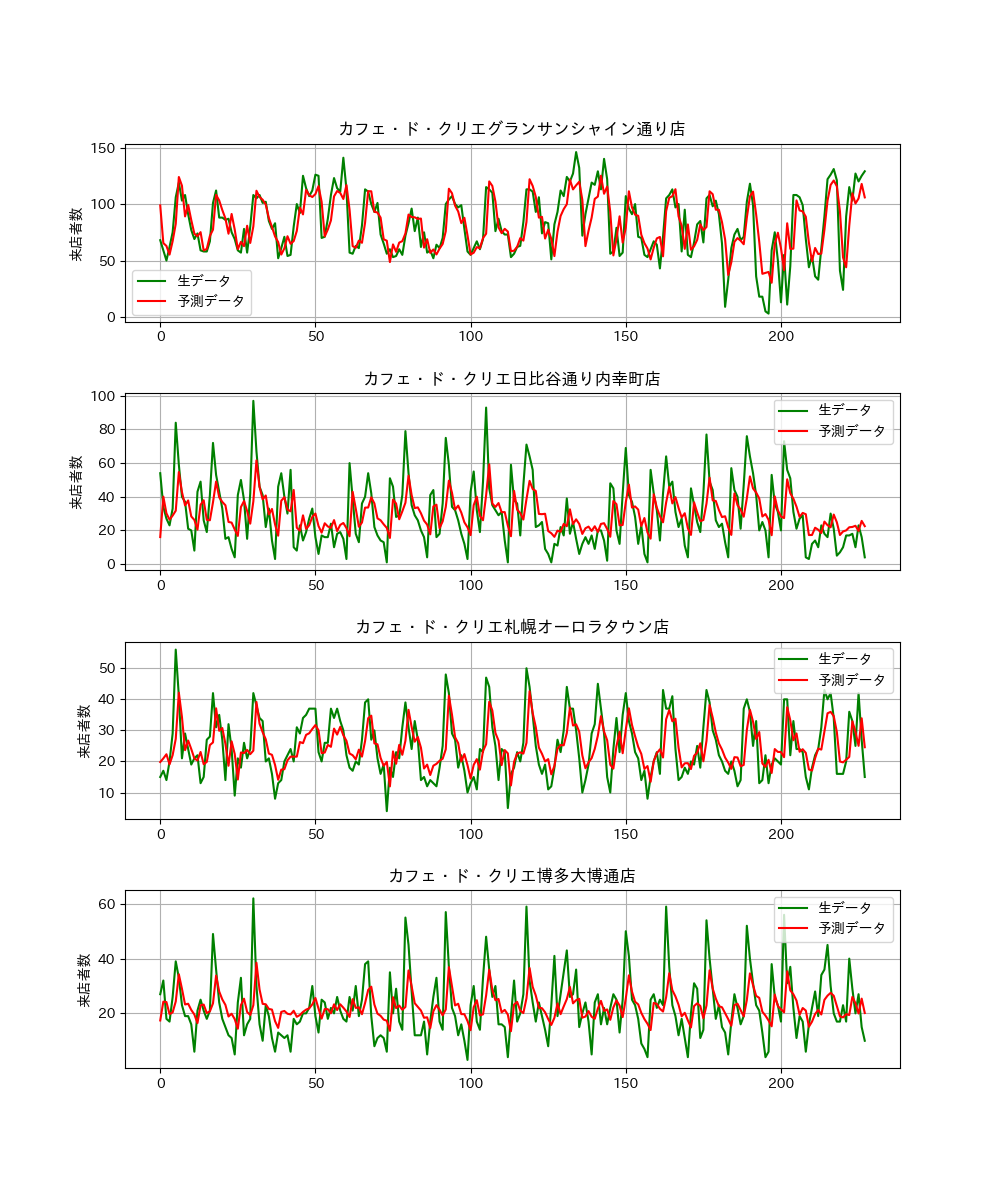

In [24]:
model  = Non_Negative_Vector_Auto_Regressive(x_test)

lag = 4
model.fit(lags=lag)

num = len(x_test)
mean = []
for idx in range(lag, num):
	test_data = []
	for idx2 in range(0, lag):
		test_data = test_data + x_test[idx - idx2 - 1]
	tmp = model.predict([test_data])
	mean.append(tmp[0])

x_test, mean = np.array(x_test), np.array(mean)
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
plt.plot(x_test[lag:, 0], "-", color="green", label="生データ")
plt.plot(mean[:, 0],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエグランサンシャイン通り店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_test[lag:, 1], "-", color="green", label="生データ")
plt.plot(mean[:, 1],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ日比谷通り内幸町店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.plot(x_test[lag:, 2], "-", color="green", label="生データ")
plt.plot(mean[:, 2],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ札幌オーロラタウン店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
plt.plot(x_test[lag:, 3], "-", color="green", label="生データ")
plt.plot(mean[:, 3],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ博多大博通店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()


model.stat_inf()

In [25]:
lag = model.select_order(maxlag=20, ic="hqic", isVisible=True)
lag = 4
model.fit(lags=lag)

SVAR model | hqic
SVAR(1) | 8.702924563966798
SVAR(2) | 8.956253935089986
SVAR(3) | 9.194494093349004
SVAR(4) | 9.412126405553922
SVAR(5) | 9.665459583814949
SVAR(6) | 9.900033287190238
SVAR(7) | 10.105757743521
SVAR(8) | 10.251738747047622
SVAR(9) | 10.393450073978787
SVAR(10) | 10.612715610885061
SVAR(11) | 10.771867355784114
SVAR(12) | 10.718557008128016
SVAR(13) | 10.632381033051228
SVAR(14) | 10.85776968480187
SVAR(15) | 11.019838441638877
SVAR(16) | 11.242792148233455
SVAR(17) | 11.37255414584003
SVAR(18) | 11.517602586371495
SVAR(19) | 11.660961728366097
SVAR(20) | 11.863582400935638
selected orders | 1


True

{'mean': array([[ 0.0042],
        [ 0.0019],
        [-0.0052],
        [ 0.0045]])}

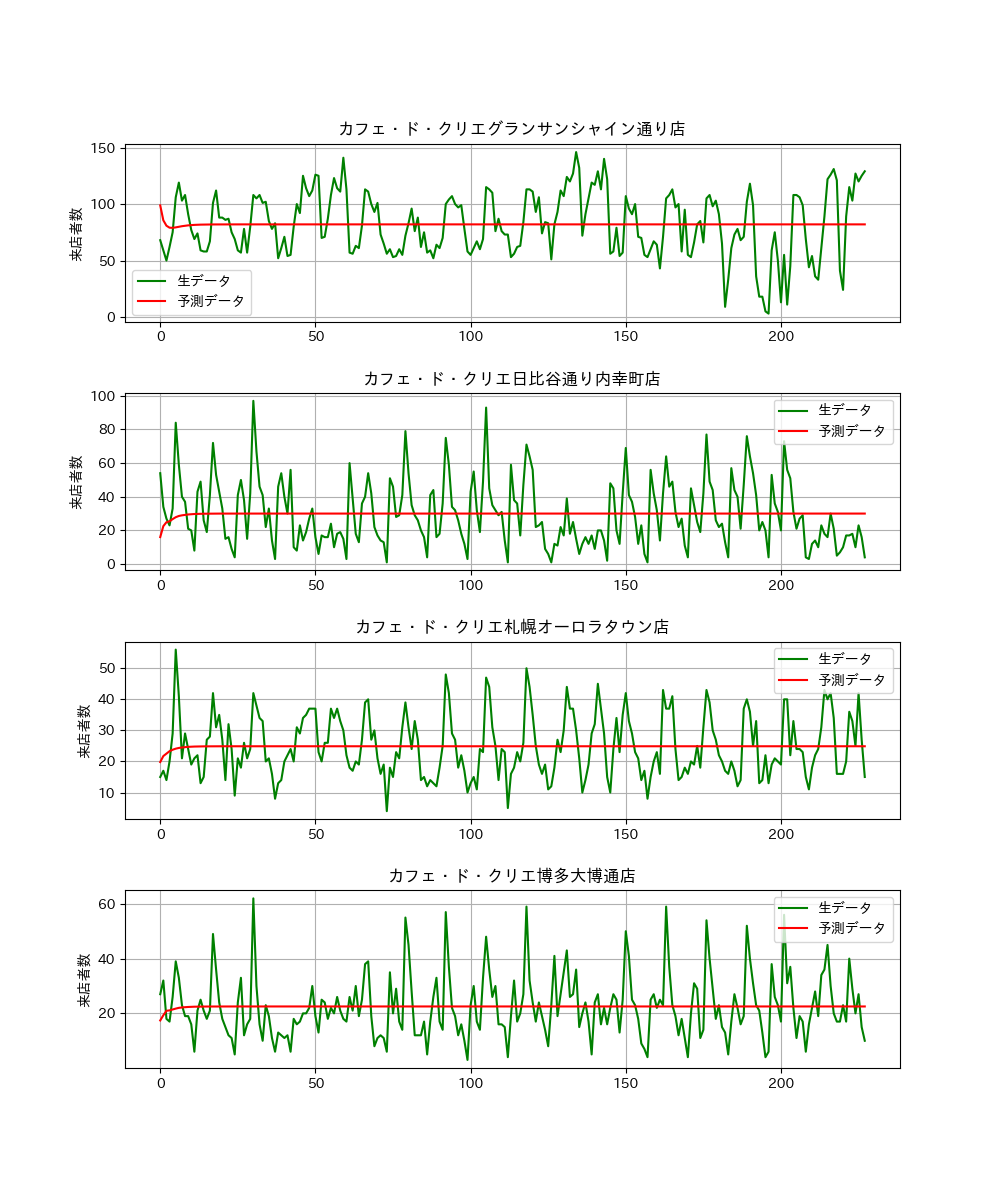

In [26]:
x_train, x_test = x_data[0:3600], x_data[3600:]
num = len(x_test)
mean = []
test_data = []
for idx in range(0, lag):
	test_data = test_data + x_test[lag - idx - 1]
for idx in range(lag, num):
	tmp = model.predict([test_data])
	mean.append(tmp[0])
	test_data = [*tmp[0], *test_data[0:-4]]

x_plot, mean = np.array(x_test), np.array(mean)
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
plt.plot(x_plot[lag:, 0], "-", color="green", label="生データ")
plt.plot(mean[:, 0],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエグランサンシャイン通り店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_plot[lag:, 1], "-", color="green", label="生データ")
plt.plot(mean[:, 1],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ日比谷通り内幸町店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.plot(x_plot[lag:, 2], "-", color="green", label="生データ")
plt.plot(mean[:, 2],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ札幌オーロラタウン店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
plt.plot(x_plot[lag:, 3], "-", color="green", label="生データ")
plt.plot(mean[:, 3],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ博多大博通店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

model.stat_inf()

In [27]:
print("グレンジャー因果性テスト(p値 = 0.05)")
print("")

t = model.test_causality(causing=0, caused=1)
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=0, caused=2)
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=0, caused=3)
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=1, caused=0)
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=1, caused=2)
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=1, caused=3)
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=2, caused=0)
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=2, caused=1)
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=2, caused=3)
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=3, caused=0)
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=3, caused=1)
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=3, caused=2)
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

グレンジャー因果性テスト(p値 = 0.05)

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ日比谷通り内幸町店
F検定量: 6.0682782914863866e-05    p値: 0.9999999995397093
グレンジャー因果性無し

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ札幌オーロラタウン店
F検定量: 1.8953082854327447e-05    p値: 0.9999999999550979
グレンジャー因果性無し

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ博多大博通店
F検定量: 1.4264782567557569e-05    p値: 0.9999999999745646
グレンジャー因果性無し

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエグランサンシャイン通り店
F検定量: 2.790398186704252e-05    p値: 0.9999999999026719
グレンジャー因果性無し

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエ札幌オーロラタウン店
F検定量: 0.006756605799486203    p値: 0.9999943063706036
グレンジャー因果性無し

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエ博多大博通店
F検定量: 3.254781165735721    p値: 0.5161285570182452
グレンジャー因果性無し

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエグランサンシャイン通り店
F検定量: 24.594722835089666    p値: 6.0686105432778564e-05
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエ日比谷通り内幸町店
F検定量: 7.088499545467696e-05    p値: 0.9999999993719295
グレンジャー因果性無し

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエ博多大博通店
F検定量: 1.3582254582933209    p値: 0.8514221476968368
グレンジャー因果性無し

カフェ・ド

簡易対応表
y1: グランサンシャイン通り店
y2: 日比谷通り内幸町店
y3: 札幌オーロラタウン店
y4: 博多大博通店


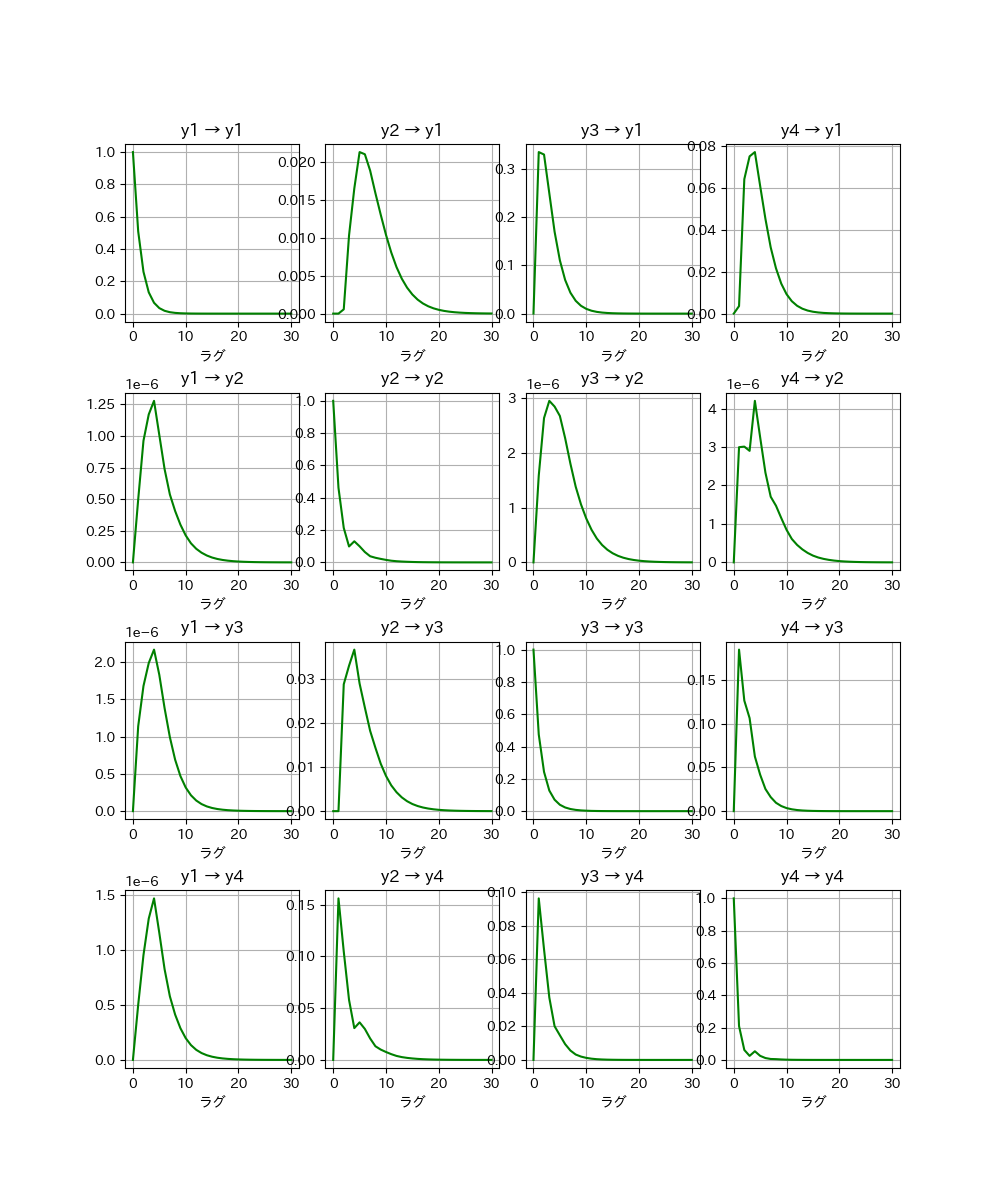

In [28]:
irf = model.irf(period=30, orth=False)

print("簡易対応表")
print("y1: グランサンシャイン通り店")
print("y2: 日比谷通り内幸町店")
print("y3: 札幌オーロラタウン店")
print("y4: 博多大博通店")

plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,4,1)
plt.plot(irf[:, 0, 0], "-", color="green", label="生データ")
plt.title("y1 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,2)
plt.plot(irf[:, 0, 1], "-", color="green", label="生データ")
plt.title("y2 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,3)
plt.plot(irf[:, 0, 2], "-", color="green", label="生データ")
plt.title("y3 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,4)
plt.plot(irf[:, 0, 3], "-", color="green", label="生データ")
plt.title("y4 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,5)
plt.plot(irf[:, 1, 0], "-", color="green", label="生データ")
plt.title("y1 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,6)
plt.plot(irf[:, 1, 1], "-", color="green", label="生データ")
plt.title("y2 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,7)
plt.plot(irf[:, 1, 2], "-", color="green", label="生データ")
plt.title("y3 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,8)
plt.plot(irf[:, 1, 3], "-", color="green", label="生データ")
plt.title("y4 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,9)
plt.plot(irf[:, 2, 0], "-", color="green", label="生データ")
plt.title("y1 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,10)
plt.plot(irf[:, 2, 1], "-", color="green", label="生データ")
plt.title("y2 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,11)
plt.plot(irf[:, 2, 2], "-", color="green", label="生データ")
plt.title("y3 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,12)
plt.plot(irf[:, 2, 3], "-", color="green", label="生データ")
plt.title("y4 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,13)
plt.plot(irf[:, 3, 0], "-", color="green", label="生データ")
plt.title("y1 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,14)
plt.plot(irf[:, 3, 1], "-", color="green", label="生データ")
plt.title("y2 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,15)
plt.plot(irf[:, 3, 2], "-", color="green", label="生データ")
plt.title("y3 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,16)
plt.plot(irf[:, 3, 3], "-", color="green", label="生データ")
plt.title("y4 → y4")
plt.xlabel("ラグ")
plt.grid(True)

簡易対応表
y1: グランサンシャイン通り店
y2: 日比谷通り内幸町店
y3: 札幌オーロラタウン店
y4: 博多大博通店


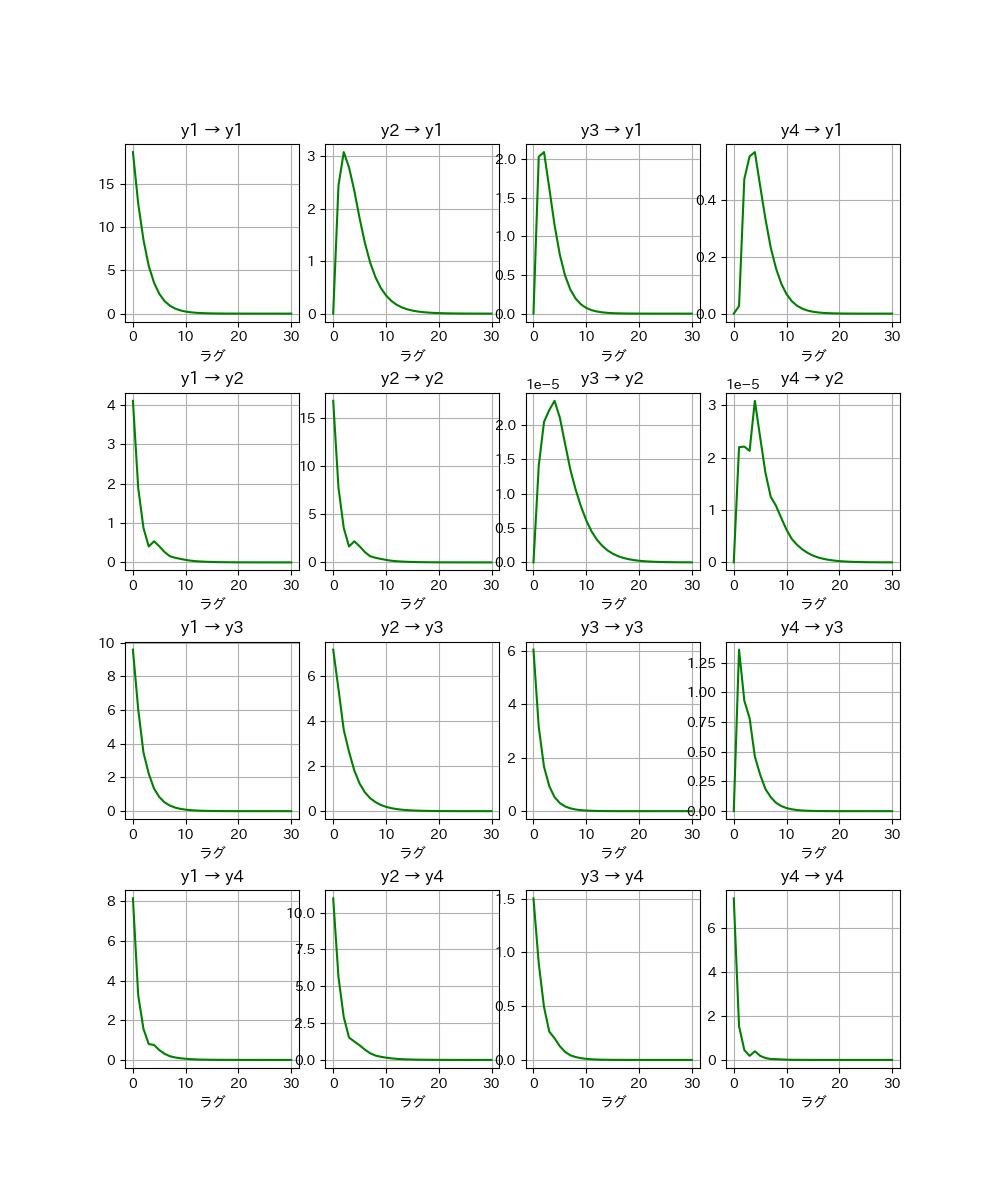

In [29]:
irf = model.irf(period=30, orth=True)

print("簡易対応表")
print("y1: グランサンシャイン通り店")
print("y2: 日比谷通り内幸町店")
print("y3: 札幌オーロラタウン店")
print("y4: 博多大博通店")

plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,4,1)
plt.plot(irf[:, 0, 0], "-", color="green", label="生データ")
plt.title("y1 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,2)
plt.plot(irf[:, 0, 1], "-", color="green", label="生データ")
plt.title("y2 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,3)
plt.plot(irf[:, 0, 2], "-", color="green", label="生データ")
plt.title("y3 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,4)
plt.plot(irf[:, 0, 3], "-", color="green", label="生データ")
plt.title("y4 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,5)
plt.plot(irf[:, 1, 0], "-", color="green", label="生データ")
plt.title("y1 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,6)
plt.plot(irf[:, 1, 1], "-", color="green", label="生データ")
plt.title("y2 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,7)
plt.plot(irf[:, 1, 2], "-", color="green", label="生データ")
plt.title("y3 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,8)
plt.plot(irf[:, 1, 3], "-", color="green", label="生データ")
plt.title("y4 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,9)
plt.plot(irf[:, 2, 0], "-", color="green", label="生データ")
plt.title("y1 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,10)
plt.plot(irf[:, 2, 1], "-", color="green", label="生データ")
plt.title("y2 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,11)
plt.plot(irf[:, 2, 2], "-", color="green", label="生データ")
plt.title("y3 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,12)
plt.plot(irf[:, 2, 3], "-", color="green", label="生データ")
plt.title("y4 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,13)
plt.plot(irf[:, 3, 0], "-", color="green", label="生データ")
plt.title("y1 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,14)
plt.plot(irf[:, 3, 1], "-", color="green", label="生データ")
plt.title("y2 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,15)
plt.plot(irf[:, 3, 2], "-", color="green", label="生データ")
plt.title("y3 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,16)
plt.plot(irf[:, 3, 3], "-", color="green", label="生データ")
plt.title("y4 → y4")
plt.xlabel("ラグ")
plt.grid(True)
plt.show()

簡易対応表
y1: グランサンシャイン通り店
y2: 日比谷通り内幸町店
y3: 札幌オーロラタウン店
y4: 博多大博通店


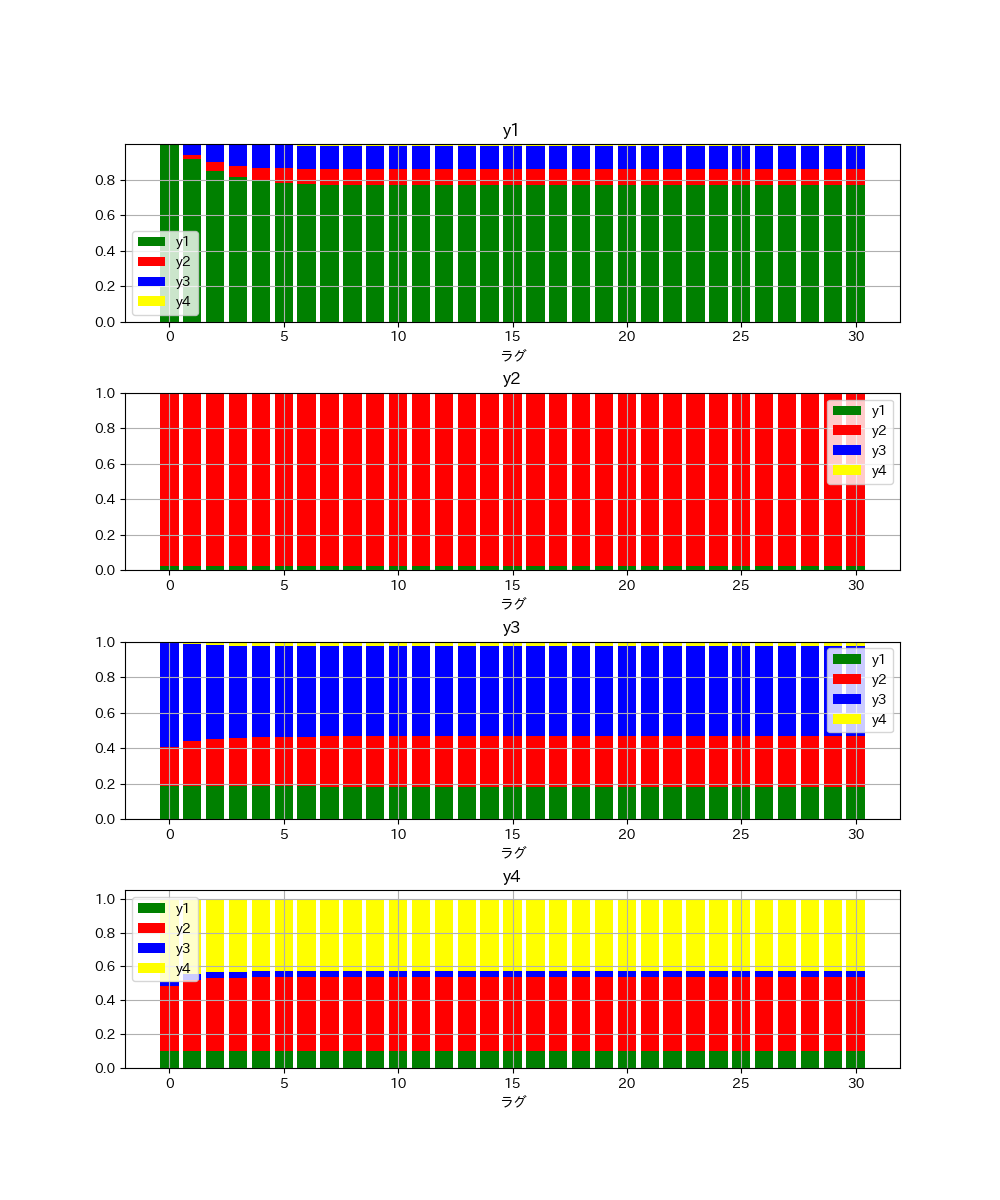

In [30]:
periods = 30
fevd = model.fevd(period=periods)
periods = len(fevd)

print("簡易対応表")
print("y1: グランサンシャイン通り店")
print("y2: 日比谷通り内幸町店")
print("y3: 札幌オーロラタウン店")
print("y4: 博多大博通店")

plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
ticks  = np.arange(periods)
lower  = np.zeros(periods)
height = fevd[:, 0, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 0, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 0, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 0, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y1")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
lower  = np.zeros(periods)
height = fevd[:, 1, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 1, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 1, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 1, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y2")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
lower  = np.zeros(periods)
height = fevd[:, 2, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 2, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 2, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 2, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y3")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
lower  = np.zeros(periods)
height = fevd[:, 3, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 3, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 3, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 3, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y4")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()